# Managing the Day-Ahead Market

electricity-market.svg

The objective of this tutorial is to demonstrate the process of running the day-ahead market. The setting we consider here includes two agents: the ISO, which manages the markets by setting the production plan and the sell and feed-in tariffs, and the PCS units (production, consumption, and storage units) that participate in the market.

## Decision-Operational Cycle:

We are considering a decision horizon of 48 half-hour intervales.

The input includes:
- the predicted demand $\hat{D}$ for each interval in the decision horizon
- the production capabitiles and costs of the ISO (and its controlled units)
- the production, storage and transmission bounds on each PCSUnit






The iterative process includes at every iteration (time 0):    
- The ISO sets the Day-Ahead Program that sets the amount of electricity to produce at each interval.
- The ISO sets the sell and feed-in tariffs per interval for the entire decision horizon.
- The PCSUnits see the prices and decide how much power to store, sell/buy and consume. In practice, all these are reflected by one decision variable that considers storage.

## Assumptions:

*   All decisions are made at time 0. This means that the policies are fixed at time 0 and while agent reazt in real-time by choosing their actions, there is no real-time adjacement of policies.  
*   As a first step, we assum that the predication




# Setting Up the energy-net Environment

In [ ]:
!git clone https://github.com/CLAIR-LAB-TECHNION/energy-net.git

%cd energy-net
!pip install -e .

In [ ]:
!python3 -m pip install ruamel.yaml
!python3 -m pip install numpy==1.23.5
!python3 -m pip install pyyaml
!python3 -m pip install tensorboard
!python3 -m pip install tqdm rich


## load PCS players and paramaters 


In [ ]:
#load pcs players - add up after training on newtown 

In [29]:
from ruamel.yaml import YAML
import os

# ---------- Block: Edit pcs_unit_config.yaml Battery Parameters ----------

edit_config = input("Do you want to edit the battery parameters in pcs_unit_config.yaml? (yes/no): ").strip().lower()

if edit_config == "yes":
    # Define the path to the YAML file; adjust if necessary.
    config_path = os.path.join("energy-net", "configs", "/Users/matanlevi/energy-net/configs/pcs_unit_config.yaml")
    
    if not os.path.exists(config_path):
        print("Error: File not found:", config_path)
        print("Current working directory is:", os.getcwd())
    else:
        yaml = YAML()
        yaml.preserve_quotes = True  # Preserve quotes and formatting
        with open(config_path, "r") as file:
            config = yaml.load(file)
        
        battery_params = config.get("battery", {}).get("model_parameters", {})
        print("\nCurrent battery parameters:")
        print(f"max: {battery_params.get('max', 'N/A')}")
        print(f"charge_rate_max: {battery_params.get('charge_rate_max', 'N/A')}")
        print(f"discharge_rate_max: {battery_params.get('discharge_rate_max', 'N/A')}")
        print(f"charge_efficiency: {battery_params.get('charge_efficiency', 'N/A')}")
        print(f"discharge_efficiency: {battery_params.get('discharge_efficiency', 'N/A')}")
        print(f"init: {battery_params.get('init', 'N/A')}")
        
        edit_choice = input("Do you want to edit these parameters? (yes/no): ").strip().lower()
        if edit_choice == "yes":
            new_max = input("Enter new max (default 100.0): ").strip() or "100.0"
            new_charge_rate_max = input("Enter new charge_rate_max (default 10.0): ").strip() or "10.0"
            new_discharge_rate_max = input("Enter new discharge_rate_max (default 10.0): ").strip() or "10.0"
            new_charge_efficiency = input("Enter new charge_efficiency (default 1.0): ").strip() or "1.0"
            new_discharge_efficiency = input("Enter new discharge_efficiency (default 1.0): ").strip() or "1.0"
            new_init = input("Enter new init (default 0.0): ").strip() or "0.0"
            
            # Update the battery parameters with the new values
            battery_params["max"] = float(new_max)
            battery_params["charge_rate_max"] = float(new_charge_rate_max)
            battery_params["discharge_rate_max"] = float(new_discharge_rate_max)
            battery_params["charge_efficiency"] = float(new_charge_efficiency)
            battery_params["discharge_efficiency"] = float(new_discharge_efficiency)
            battery_params["init"] = float(new_init)
            
            # Update the configuration dictionary
            config["battery"]["model_parameters"] = battery_params
            
            # Write the updated configuration back to the file
            try:
                with open(config_path, "w") as file:
                    yaml.dump(config, file)
                print("pcs_unit_config.yaml updated successfully.")
            except Exception as e:
                print("Error writing YAML file:", e)
        else:
            print("No changes made to pcs_unit_config.yaml.")
else:
    print("Skipping editing of pcs_unit_config.yaml battery parameters.")


# ---------- Block: PCSs Agent Selection ----------

def load_pcss(config_files):
    return f"PCSs model loaded with config(s): {config_files}"

print("\nPlease select a PCSs agent model:")
print("1: Variable prices in intervals")
print("2: Quadratic price based on demand")
print("3: Online variable price")
print("4: None")

choice = input("Enter 1, 2, 3 or 4: ").strip()

if choice == "1":
    config_files = "path/to/variable_prices_in_intervals_config.json"
elif choice == "2":
    config_files = "path/to/quadratic_price_based_on_demand_config.json"
elif choice == "3":
    config_files = "path/to/online_variable_price_config.json"
elif choice == "4":
    config_files = None
else:
    print("Invalid choice. Defaulting to option 4.")
    config_files = None

# Load the PCSs agent using the chosen configuration file (if any)
PCSs = load_pcss([config_files])
print("Loaded PCSs:", PCSs)


Skipping editing of pcs_unit_config.yaml battery parameters.

Please select a PCSs agent model:
1: Variable prices in intervals
2: Quadratic price based on demand
3: Online variable price
4: None
Loaded PCSs: PCSs model loaded with config(s): [None]


## ISO Parameter Selection

In [30]:
import random

chosen_model_path = "path/to/your/selected/model/config.json"  # Update as needed

# --- Pricing Policy Selection ---
print("Select a pricing policy:")
print("1: QUADRATIC")
print("2: ONLINE")
print("3: CONSTANT")

policy_choice = input("Enter your choice (1, 2, or 3): ").strip()

if policy_choice == "1":
    pricing_policy_str = "QUADRATIC"
elif policy_choice == "2":
    pricing_policy_str = "ONLINE"
elif policy_choice == "3":
    pricing_policy_str = "CONSTANT"
else:
    print("Invalid choice. Defaulting to QUADRATIC.")
    pricing_policy_str = "QUADRATIC"

# --- Training Parameter Inputs ---
try:
    total_iterations = int(input("Enter total_iterations (e.g. 10): ").strip())
except:
    total_iterations = 10

try:
    train_timesteps_per_iteration = int(input("Enter train_timesteps_per_iteration (e.g. 10000): ").strip())
except:
    train_timesteps_per_iteration = 10000

try:
    eval_episodes = int(input("Enter eval_episodes (e.g. 5): ").strip())
except:
    eval_episodes = 5

# --- Random Seed Generation ---
seed = random.randint(0, 10000)
print(f"Randomly selected seed: {seed}")

# --- Store parameters in a dictionary ---
iso_params = {
    "trained_pcs_model_path": chosen_model_path,
    "pricing_policy_str": pricing_policy_str,
    "total_iterations": total_iterations,
    "train_timesteps_per_iteration": train_timesteps_per_iteration,
    "eval_episodes": eval_episodes,
    "seed": seed
}

print("ISO training parameters:")
print(iso_params)


Select a pricing policy:
1: QUADRATIC
2: ONLINE
3: CONSTANT
Randomly selected seed: 5551
ISO training parameters:
{'trained_pcs_model_path': 'path/to/your/selected/model/config.json', 'pricing_policy_str': 'QUADRATIC', 'total_iterations': 10, 'train_timesteps_per_iteration': 10, 'eval_episodes': 5, 'seed': 5551}


# Training ISO agent

In [31]:
from iso_game_main import train_and_evaluate_agent, PricingPolicy

# Convert the pricing policy string to the corresponding enum value.
if iso_params["pricing_policy_str"] == "QUADRATIC":
    pricing_policy_enum = PricingPolicy.QUADRATIC
elif iso_params["pricing_policy_str"] == "ONLINE":
    pricing_policy_enum = PricingPolicy.ONLINE
elif iso_params["pricing_policy_str"] == "CONSTANT":
    pricing_policy_enum = PricingPolicy.CONSTANT
else:
    pricing_policy_enum = PricingPolicy.QUADRATIC

print("Starting ISO training...")
train_and_evaluate_agent(
    algo_type='PPO',
    trained_pcs_model_path=iso_params["trained_pcs_model_path"],
    pricing_policy=pricing_policy_enum,
    total_iterations=iso_params["total_iterations"],
    train_timesteps_per_iteration=iso_params["train_timesteps_per_iteration"],
    eval_episodes=iso_params["eval_episodes"],
    seed=iso_params["seed"]
)


Starting ISO training...
Using cpu device
Starting iterative training for 10 iterations.
Training ISO, using current ISO model
Logging to logs/agent_iso/PPO_11


Output()

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 48        |
|    ep_rew_mean     | -1.02e+08 |
| time/              |           |
|    fps             | 249       |
|    iterations      | 1         |
|    time_elapsed    | 8         |
|    total_timesteps | 2048      |
----------------------------------


[ISO] Mean Reward: -87943042.42 +/- 51033909.08
Saved flows and prices plot to logs/agent_iso/episode_0_flows_prices.png
Saved cost components plot to logs/agent_iso/episode_0_cost_components.png
Saved final cost distribution plot to logs/agent_iso/episode_0_final_cost_distribution.png
Training ISO, using current ISO model
Logging to logs/agent_iso/PPO_12


Output()

-----------------------------
| time/              |      |
|    fps             | 225  |
|    iterations      | 1    |
|    time_elapsed    | 9    |
|    total_timesteps | 2048 |
-----------------------------


Runtime info saved to runtime_info.pkl

[ISO] Mean Reward: -82922333.07 +/- 57243252.12
Saved flows and prices plot to logs/agent_iso/episode_1_flows_prices.png
Saved cost components plot to logs/agent_iso/episode_1_cost_components.png
Saved final cost distribution plot to logs/agent_iso/episode_1_final_cost_distribution.png
Training ISO, using current ISO model
Logging to logs/agent_iso/PPO_13


Output()

-----------------------------
| time/              |      |
|    fps             | 258  |
|    iterations      | 1    |
|    time_elapsed    | 7    |
|    total_timesteps | 2048 |
-----------------------------


Runtime info saved to runtime_info.pkl

[ISO] Mean Reward: -136399242.49 +/- 70242150.28
Saved flows and prices plot to logs/agent_iso/episode_2_flows_prices.png
Saved cost components plot to logs/agent_iso/episode_2_cost_components.png
Saved final cost distribution plot to logs/agent_iso/episode_2_final_cost_distribution.png
Training ISO, using current ISO model
Logging to logs/agent_iso/PPO_14


Output()

-----------------------------
| time/              |      |
|    fps             | 311  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------


Runtime info saved to runtime_info.pkl

[ISO] Mean Reward: -99214917.17 +/- 83072633.66
Saved flows and prices plot to logs/agent_iso/episode_3_flows_prices.png
Saved cost components plot to logs/agent_iso/episode_3_cost_components.png
Saved final cost distribution plot to logs/agent_iso/episode_3_final_cost_distribution.png
Training ISO, using current ISO model
Logging to logs/agent_iso/PPO_15


Output()

-----------------------------
| time/              |      |
|    fps             | 299  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------


Runtime info saved to runtime_info.pkl

[ISO] Mean Reward: -72592345.13 +/- 40323164.18
Saved flows and prices plot to logs/agent_iso/episode_4_flows_prices.png
Saved cost components plot to logs/agent_iso/episode_4_cost_components.png
Saved final cost distribution plot to logs/agent_iso/episode_4_final_cost_distribution.png
Training ISO, using current ISO model
Logging to logs/agent_iso/PPO_16


Output()

-----------------------------
| time/              |      |
|    fps             | 280  |
|    iterations      | 1    |
|    time_elapsed    | 7    |
|    total_timesteps | 2048 |
-----------------------------


Runtime info saved to runtime_info.pkl

[ISO] Mean Reward: -111457024.15 +/- 43103852.39
Saved flows and prices plot to logs/agent_iso/episode_5_flows_prices.png
Saved cost components plot to logs/agent_iso/episode_5_cost_components.png
Saved final cost distribution plot to logs/agent_iso/episode_5_final_cost_distribution.png
Training ISO, using current ISO model
Logging to logs/agent_iso/PPO_17


Output()

-----------------------------
| time/              |      |
|    fps             | 302  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------


[ISO] Mean Reward: -86081920.34 +/- 76611225.76
Saved flows and prices plot to logs/agent_iso/episode_6_flows_prices.png
Saved cost components plot to logs/agent_iso/episode_6_cost_components.png
Saved final cost distribution plot to logs/agent_iso/episode_6_final_cost_distribution.png
Training ISO, using current ISO model
Logging to logs/agent_iso/PPO_18


Output()

-----------------------------
| time/              |      |
|    fps             | 330  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------


Runtime info saved to runtime_info.pkl

[ISO] Mean Reward: -69170999.56 +/- 66727379.41
Saved flows and prices plot to logs/agent_iso/episode_7_flows_prices.png
Saved cost components plot to logs/agent_iso/episode_7_cost_components.png
Saved final cost distribution plot to logs/agent_iso/episode_7_final_cost_distribution.png
Training ISO, using current ISO model
Logging to logs/agent_iso/PPO_19


Output()

-----------------------------
| time/              |      |
|    fps             | 347  |
|    iterations      | 1    |
|    time_elapsed    | 5    |
|    total_timesteps | 2048 |
-----------------------------


Runtime info saved to runtime_info.pkl

[ISO] Mean Reward: -110821029.13 +/- 114966370.29
Saved flows and prices plot to logs/agent_iso/episode_8_flows_prices.png
Saved cost components plot to logs/agent_iso/episode_8_cost_components.png
Saved final cost distribution plot to logs/agent_iso/episode_8_final_cost_distribution.png
Training ISO, using current ISO model
Logging to logs/agent_iso/PPO_20


Output()

-----------------------------
| time/              |      |
|    fps             | 314  |
|    iterations      | 1    |
|    time_elapsed    | 6    |
|    total_timesteps | 2048 |
-----------------------------


Runtime info saved to runtime_info.pkl

[ISO] Mean Reward: -135819449.80 +/- 76213192.89
Saved flows and prices plot to logs/agent_iso/episode_9_flows_prices.png
Saved cost components plot to logs/agent_iso/episode_9_cost_components.png
Saved final cost distribution plot to logs/agent_iso/episode_9_final_cost_distribution.png
Iterative training completed.
Final ISO model saved to models/agent_iso/agent_iso_final.zip
Training and evaluation process completed.
Final ISO Model - Mean Reward: -71253433.7783229 +/- 55040143.06998036


# Eval / Visualizations

In [ ]:
import subprocess
import random

# ----------------- Evaluation Parameter Selection -----------------
print("Please provide evaluation parameters for evaluation:")

# Defaults from your training output:
trained_model_path = "models/agent_iso/agent_iso_final.zip"
normalizer_path = "models/agent_iso/agent_iso_normalizer.pkl"

# For the trained_pcs_model_path, we set the default as the string "None"
trained_pcs_model_path = "None"

print(f"Default trained model path: {trained_model_path}")
print(f"Default normalizer path: {normalizer_path}")
print(f"Default trained PCS model path: {trained_pcs_model_path}")

# Pricing policy selection for evaluation
print("Select a pricing policy for evaluation:")
print("1: QUADRATIC")
print("2: ONLINE")
print("3: CONSTANT")
policy_choice = input("Enter your choice (1, 2, or 3): ").strip()

if policy_choice == "1":
    pricing_policy_str = "QUADRATIC"
elif policy_choice == "2":
    pricing_policy_str = "ONLINE"
elif policy_choice == "3":
    pricing_policy_str = "CONSTANT"
else:
    print("Invalid choice. Defaulting to QUADRATIC.")
    pricing_policy_str = "QUADRATIC"

# Number of evaluation episodes
try:
    eval_episodes = int(input("Enter the number of evaluation episodes (e.g., 5): ").strip())
except Exception as e:
    print("Invalid input. Defaulting to 5 episodes.")
    eval_episodes = 5

seed = random.randint(0, 10000)
print(f"Randomly selected internal seed (not passed to eval_agent.py): {seed}")

# ----------------- Run Evaluation via eval_agent.py -----------------
# Construct the command to run eval_agent.py with the required arguments.
command = [
    "python3", "eval_agent.py",
    "--trained_model_path", trained_model_path,
    "--trained_pcs_model_path", trained_pcs_model_path,
    "--normalizer_path", normalizer_path,
    "--pricing_policy", pricing_policy_str,
    "--eval_episodes", str(eval_episodes)
]

print("\nRunning evaluation with the following command:")
print(" ".join(command))
result = subprocess.run(command, capture_output=True, text=True)

print("\nEvaluation Output:")
print(result.stdout)
if result.stderr:
    print("Evaluation Errors:")
    print(result.stderr)


Please provide evaluation parameters for evaluation:
Default trained model path: models/agent_iso/agent_iso_final.zip
Default normalizer path: models/agent_iso/agent_iso_normalizer.pkl
Default trained PCS model path: None
Select a pricing policy for evaluation:
1: QUADRATIC
2: ONLINE
3: CONSTANT
Randomly selected internal seed (not passed to eval_agent.py): 4476

Running evaluation with the following command:
python3 eval_agent.py --trained_model_path models/agent_iso/agent_iso_final.zip --trained_pcs_model_path None --normalizer_path models/agent_iso/agent_iso_normalizer.pkl --pricing_policy QUADRATIC --eval_episodes 2


Python(24897) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.



Evaluation Output:
Registering PCSUnitEnv-v0
Registering ISOEnv-v0

Starting Episode 1/2
Episode 1 completed - Reward: -94753960.62
Saved flows and prices plot to evaluation_results/episode_0_flows_prices.png
Saved cost components plot to evaluation_results/episode_0_cost_components.png
Saved final cost distribution plot to evaluation_results/episode_0_final_cost_distribution.png

Starting Episode 2/2
Episode 2 completed - Reward: -10072905.88
Saved flows and prices plot to evaluation_results/episode_1_flows_prices.png
Saved cost components plot to evaluation_results/episode_1_cost_components.png
Saved final cost distribution plot to evaluation_results/episode_1_final_cost_distribution.png
Evaluation completed - Check evaluation_results directory for plots



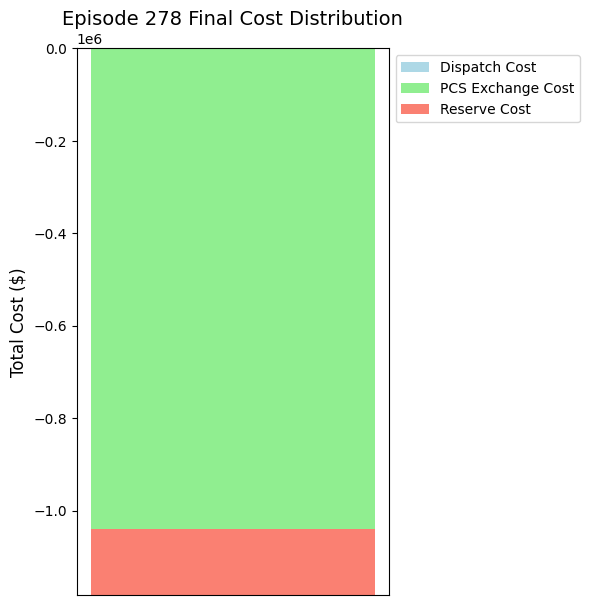

In [ ]:
import pickle
import matplotlib.pyplot as plt

# Load runtime info (a list of episodes, each being a list of step dictionaries)
data_file = "runtime_info.pkl"
with open(data_file, "rb") as f:
    all_episodes_actions = pickle.load(f)

episode_number = random.randint(1, len(all_episodes_actions)) # maybe should change

if len(all_episodes_actions) < episode_number:
    print(f"Only {len(all_episodes_actions)} episodes available; cannot display episode {episode_number}.")
else:
    episode_data = all_episodes_actions[episode_number - 1]
    
    # Compute cost components as in your callbacks:
    dispatch_costs = [step.get('dispatch_cost', 0.0) for step in episode_data]
    pcs_costs = [
        step.get('net_exchange', 0.0) * 
        (step.get('iso_sell_price', 0.0) if step.get('net_exchange', 0.0) > 0 
         else step.get('iso_buy_price', 0.0))
        for step in episode_data
    ]
    reserve_costs = [step.get('reserve_cost', 0.0) for step in episode_data]
    
    total_dispatch = sum(dispatch_costs)
    total_pcs = sum(pcs_costs)
    total_reserve = sum(reserve_costs)
    
    # Create the final cost distribution figure (similar to Figure 3 in your callback)
    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(1, 1, 1)
    
    ax.bar([0], [total_dispatch], color='lightblue', label='Dispatch Cost')
    ax.bar([0], [total_pcs], bottom=[total_dispatch], color='lightgreen', label='PCS Exchange Cost')
    ax.bar([0], [total_reserve], bottom=[total_dispatch + total_pcs], color='salmon', label='Reserve Cost')
    
    ax.set_ylabel('Total Cost ($)', fontsize=12)
    ax.set_title(f'Episode {episode_number} Final Cost Distribution', fontsize=14)
    ax.set_xticks([])
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=10)
    
    plt.tight_layout()
    plt.show()


Loaded runtime data with 420 episodes.


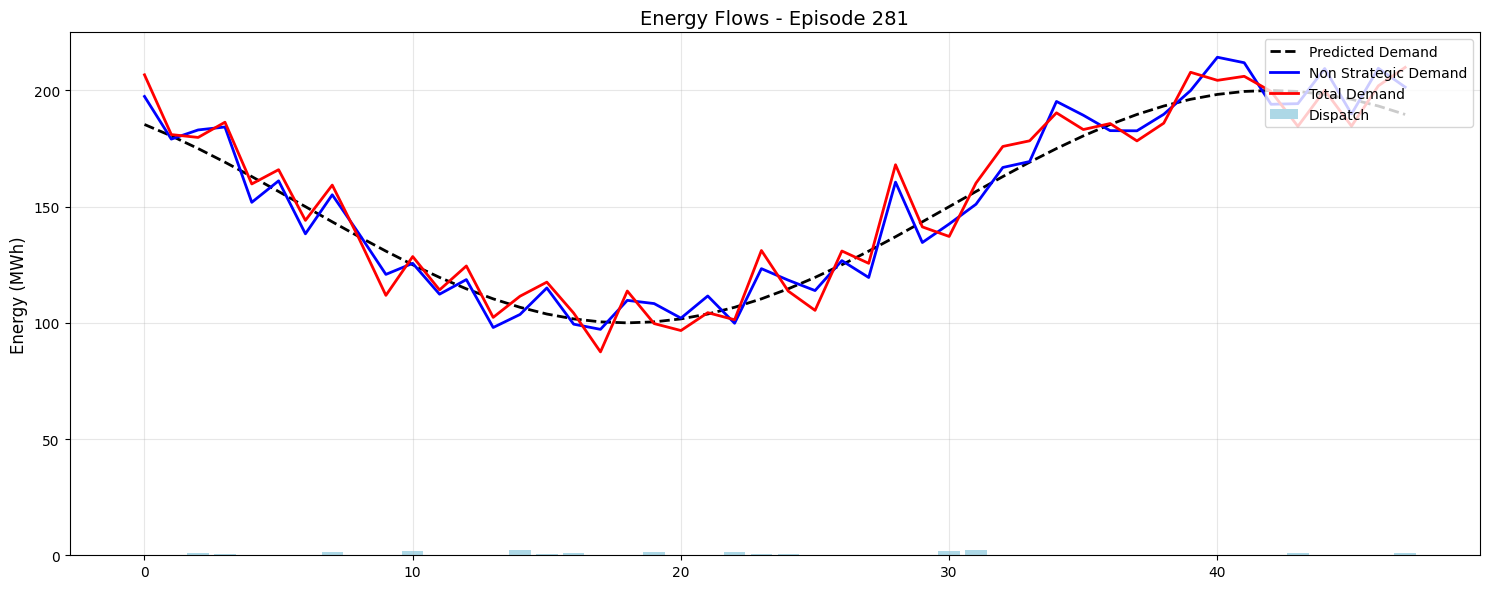

In [ ]:
import pickle
import matplotlib.pyplot as plt

# Load runtime data from file (this file should have been created by your callback)
runtime_file = "runtime_info.pkl"
try:
    with open(runtime_file, "rb") as f:
        all_episodes_actions = pickle.load(f)
    print(f"Loaded runtime data with {len(all_episodes_actions)} episodes.")
except Exception as e:
    print("Error loading runtime data:", e)
    all_episodes_actions = []

# Define the episode number to plot (Episode 9)
episode_num = random.randint(1, len(all_episodes_actions))   


if len(all_episodes_actions) < episode_num:
    print(f"Only {len(all_episodes_actions)} episodes available; cannot plot episode {episode_num}.")
else:
    episode_data = all_episodes_actions[episode_num - 1]
    
    # Extract data from the episode
    steps = [step.get('step', 0) for step in episode_data]
    dispatch = [step.get('dispatch', 0.0) for step in episode_data]
    predicted_demand = [step.get('predicted_demand', 0.0) for step in episode_data]
    realized_demand = [step.get('realized_demand', 0.0) for step in episode_data]
    net_exchange = [step.get('net_exchange', 0.0) for step in episode_data]
    
    # Compute total (net) demand: realized_demand + net_exchange
    net_demand = [r + n for r, n in zip(realized_demand, net_exchange)]
    
    # Create the plot replicating the upper graph ("Energy Flows")
    plt.figure(figsize=(15, 6))  
    plt.bar(steps, dispatch, width=0.8, color='lightblue', label='Dispatch')
    plt.plot(steps, predicted_demand, 'k--', linewidth=2, label='Predicted Demand')
    plt.plot(steps, realized_demand, 'b-', linewidth=2, label='Non Strategic Demand')
    plt.plot(steps, net_demand, 'r-', linewidth=2, label='Total Demand')
    
    plt.ylabel('Energy (MWh)', fontsize=12)
    plt.title(f'Energy Flows - Episode {episode_num}', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='upper right', fontsize=10)
    plt.tight_layout()
    plt.show()


In [ ]:
#TODO graph Itay
# predicted demand

In [ ]:
#TODO graph throughout training Sarah
# cost

In [ ]:
#TODO eval

\

---



---



---



In [ ]:
import os
import yaml
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym
# import the ISOs
from energy_net.dynamics.iso.hourly_pricing_iso import HourlyPricingISO
from energy_net.dynamics.iso.random_pricing_iso import RandomPricingISO
from energy_net.dynamics.iso.quadratic_pricing_iso import QuadraticPricingISO
from energy_net.dynamics.iso.time_of_use_pricing_iso import TimeOfUsePricingISO
from energy_net.dynamics.iso.dynamic_pricing_iso import DynamicPricingISO

# Reward import
from energy_net.rewards.cost_reward import CostReward
# Instantiate the CostReward class
reward_calc = CostReward()

sns.set_theme(style="whitegrid", font_scale=1.2)
%matplotlib inline

# ISOs

### HourlyPricingISO

The `HourlyPricingISO` sets a specific price for each hour of the day. We pass a dictionary `hourly_rates` that maps `hour -> price`.

Given a time (as a fraction of the day, where `0.0` is midnight and `1.0` is the next midnight), the ISO determines the current hour and sets a buy price. The sell price is a fraction (e.g., 90%) of the buy price.

The reward for a given transaction (`buy_amount`, `sell_amount`) is calculated as:

$$
\text{Reward} = (\text{buy_amount} \times \text{price_buy}) - (\text{sell_amount} \times \text{price_sell})
$$


In [ ]:
# HourlyPricingISO
# Here we define hourly rates that vary slightly by hour using a sine function for illustrative purposes.
hourly_rates = {hour: 50.0 + 10*np.sin(np.pi * hour/24) for hour in range(24)}

hp_iso = HourlyPricingISO(hourly_rates=hourly_rates)

times = np.linspace(0,1,100)  # Times as fractions of the day (0 = 0:00, 1 = 24:00)

hourly_rewards = []
hourly_prices = []
for t in times:
    pricing_func = hp_iso.get_pricing_function({'time': t})
    # To extract the current hour:
    current_hour = int(t*24) % 24
    price = hourly_rates.get(current_hour, 50.0)
    # Use the CostReward to compute reward
    info = {
        'pricing_function': pricing_func
    }
    reward = reward_calc.compute_reward(info)
    hourly_rewards.append(reward)
    hourly_prices.append(price)

hourly_prices = np.array(hourly_prices)
hours = times * 24

# Plotting the prices
plt.figure(figsize=(12,6))
plt.plot(hours, hourly_prices[:], label=' Price', color='blue')

plt.title('HourlyPricingISO Prices Over Time')
plt.xlabel('Hour of Day')
plt.ylabel('Price ($/MWh)')
plt.legend()
plt.grid(True)
plt.show()



## RandomPricingISO Plot

For the `RandomPricingISO`, the prices are random each time get_pricing_function is called. We'll just sample multiple pricing functions and record the resulting rewards distribution for a fixed buy/sell scenario.

In [ ]:
rp_iso = RandomPricingISO(min_price=40.0, max_price=60.0)

num_samples = 1000
buy_amount = 10

random_rewards = []
random_buy_prices = []
random_sell_prices = []

for _ in range(num_samples):
    pricing_func = rp_iso.get_pricing_function({})
    # We don't directly know the buy/sell price without re-generating them,
    # but we can assume it's stable for that call. Let's just call the function with 1 unit to guess prices.
    # Actually, to extract prices, let's trick the pricing function:
    # If we define a small system of equations:
    # reward = buy*price_buy - sell*price_sell
    # If we call pricing(1,0) = price_buy
    # pricing(0,1) = -price_sell
    price_buy = pricing_func(1)


    # Use the CostReward to compute reward
    info = {
        'pricing_function': pricing_func
    }
    reward = reward_calc.compute_reward(info)
    random_rewards.append(reward)
    random_buy_prices.append(price_buy)


plt.figure(figsize=(12,6))
sns.histplot(random_buy_prices, kde=True, color='blue', label='Prices')

plt.title('RandomPricingISO Price Distribution')
plt.xlabel('Price ($/MWh)')
plt.ylabel('Frequency')
plt.legend()
plt.show()



### QuadraticPricingISO

The `QuadraticPricingISO` computes the buy price using a quadratic function of demand:

$$
\text{price_buy}(d) = a \cdot d^2 + b \cdot d + c
$$

The sell price is a fixed fraction (e.g., 85%) of the buy price.

The reward calculation follows the same form as before:

$$
\text{Reward} = (\text{buy_amount} \times \text{price_buy}) - (\text{sell_amount} \times \text{price_sell})
$$


In [ ]:
demands = np.linspace(0,3,100)
param_sets = [
    (1.0, 0.0, 50.0),
    (0.5, 0.0, 50.0),
    (1.0, 2.0, 50.0),
    (1.0, 0.0, 60.0)
]

plt.figure(figsize=(12,6))
for (a, b, c) in param_sets:
    qp_iso = QuadraticPricingISO(a=a, b=b, c=c)
    q_prices_buy = []
    for d in demands:
        pricing_func = qp_iso.get_pricing_function({'demand': d})
        # Compute price_buy to plot (not directly needed for reward since we have pricing_func)
        price_buy = a*(d**2) + b*d + c
        q_prices_buy.append(price_buy)
    plt.plot(demands, q_prices_buy, label=f'a={a}, b={b}, c={c}')

plt.title('QuadraticPricingISO - Price under Different (a,b,c)')
plt.xlabel('Demand')
plt.ylabel('Price ($/MWh)')
plt.legend()
plt.grid(True)
plt.show()



## TimeOfUsePricingISO Plot

- The `TimeOfUsePricingISO` defines certain hours as peak and others as off-peak, with corresponding prices. Hours not in either category use a default price (average of peak and off-peak).
- We will show multiple instances of `TimeOfUsePricingISO` with different parameters to illustrate how these choices affect pricing.

In [1]:
times = np.linspace(0,1,100)
hours = times*24
buy_amount = 10


# Define different TOU setups to compare
tou_setups = [
    {
        'peak_hours': [17,18,19],
        'off_peak_hours': [0,1,2,3,4,5],
        'peak_price': 60.0,
        'off_peak_price': 30.0,
        'label': 'Setup 1 (peak: 17-19, off-peak: 0-5)'
    },
    {
        'peak_hours': [16,17,18],
        'off_peak_hours': [22,23,0,1],
        'peak_price': 70.0,
        'off_peak_price': 20.0,
        'label': 'Setup 2 (peak:16-18, off-peak:22-1)'
    }
]

plt.figure(figsize=(12,6))
for setup in tou_setups:
    tou_iso = TimeOfUsePricingISO(
        peak_hours=setup['peak_hours'],
        off_peak_hours=setup['off_peak_hours'],
        peak_price=setup['peak_price'],
        off_peak_price=setup['off_peak_price']
    )
    tou_prices_buy = []
    for t in times:
        pricing_func = tou_iso.get_pricing_function({'time': t})
        # Determine buy price for plotting (as done before)
        current_hour = int(t*24)%24
        if current_hour in setup['peak_hours']:
            price_buy = setup['peak_price']
        elif current_hour in setup['off_peak_hours']:
            price_buy = setup['off_peak_price']
        else:
            price_buy = (setup['peak_price'] + setup['off_peak_price'])/2
        tou_prices_buy.append(price_buy)

    plt.plot(hours, tou_prices_buy, label=setup['label'])

plt.title('TimeOfUsePricingISO - Price under Different Setups')
plt.xlabel('Hour of Day')
plt.ylabel('Price ($/MWh)')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'np' is not defined

### DynamicPricingISO

The `DynamicPricingISO` adjusts prices based on both demand and supply, using an elasticity factor.

The price is computed as:

$$
\text{price_buy} = \text{base_price} \times \left[ 1 + \text{elasticity} \times (\text{demand} - \text{supply}) \right]
$$

The sell price is a fraction of the buy price.

By creating a 2D grid of `(demand, supply)` values and computing the resulting reward, we can visualize this relationship as a heatmap. This tool allows us to see how changes in these two factors affect the system's output (reward).

A heatmap is useful because it provides a quick overview of the reward landscape for different states, showing where high rewards or low rewards occur as we vary both demand and supply simultaneously.


In [ ]:
dp_iso = DynamicPricingISO(base_price=50.0, elasticity=0.5)

demands = np.linspace(0,2,50)
supplies = np.linspace(0,2,50)

buy_amount = 1


rewards_matrix = np.zeros((len(demands), len(supplies)))

for i, d in enumerate(demands):
    for j, s in enumerate(supplies):
        pricing_func = dp_iso.get_pricing_function({'demand': d, 'supply': s})
        info = {
            'pricing_function': pricing_func,
            'net_exchange': buy_amount
        }
        reward = reward_calc.compute_reward(info)
        rewards_matrix[i,j] = reward

plt.figure(figsize=(10,8))

ax = sns.heatmap(
    rewards_matrix,
    cmap='viridis',
    cbar_kws={"shrink": 0.8}
)

plt.title('DynamicPricingISO Reward Heatmap (Demand vs. Supply)')
plt.xlabel('Supply')
plt.ylabel('Demand')


num_ticks = 5

# Indices at which to place ticks
x_ticks = np.linspace(0, len(supplies)-1, num_ticks).astype(int)
y_ticks = np.linspace(0, len(demands)-1, num_ticks).astype(int)

# Corresponding values at these indices
x_tick_labels = [f"{supplies[i]:.1f}" for i in x_ticks]
y_tick_labels = [f"{demands[i]:.1f}" for i in y_ticks]

# Set the ticks
plt.xticks(x_ticks + 0.5, x_tick_labels, rotation=0)  # +0.5 to center labels between cells
plt.yticks(y_ticks + 0.5, y_tick_labels, rotation=0)

plt.show()


In [ ]:
import os
import pandas as pd

from stable_baselines3 import TD3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
import energy_net.env

# Make plots inline and set a nice style
%matplotlib inline
sns.set_theme(style="whitegrid")

# Training

In [ ]:
class RewardCallback(BaseCallback):
        """
        Custom callback for recording episode rewards during training.
        """
        def __init__(self, verbose=0):
            super(RewardCallback, self).__init__(verbose)
            self.rewards = []

        def _on_step(self) -> bool:
            # Check if an episode has finished
            for info in self.locals.get('infos', []):
                if 'episode' in info.keys():
                    self.rewards.append(info['episode']['r'])
            return True

reward_callback = RewardCallback()

In [ ]:
# Paths
env_id = 'PCSUnitEnv-v0'
env_config_path = 'configs/environment_config.yaml'
iso_config_path = 'configs/iso_config.yaml'
pcs_unit_config_path = 'configs/pcs_unit_config.yaml'

log_dir = 'logs/TD3_energy_net_env'
model_path = 'models/TD3_energy_net_env/TD3_energy_net_env'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(os.path.dirname(model_path), exist_ok=True)

########################################
# Training
########################################

# Create training environment
train_env = gym.make(
    env_id,
    disable_env_checker=True,
    env_config_path=env_config_path,
    iso_config_path=iso_config_path,
    pcs_unit_config_path=pcs_unit_config_path,
    log_file=os.path.join(log_dir, 'train_environment.log')
)
train_env.reset(seed=42)
train_env.action_space.seed(42)
train_env.observation_space.seed(42)

# Instantiate TD3 model
model = TD3(
    'MlpPolicy',
    train_env,
    verbose=1,
    tensorboard_log=log_dir,
    seed=42
)

total_timesteps = 30_000  # Adjust as needed
print("Starting training...")
model.learn(total_timesteps=total_timesteps, callback=reward_callback, progress_bar=True)
print("Training completed.")

# Save the trained model
model.save(model_path)
print(f"Model saved at {model_path}.zip")

train_env.close()

In [ ]:
model = TD3.load(model_path)
eval_episodes = 1

eval_env = gym.make(
    env_id,
    disable_env_checker=True,
    env_config_path=env_config_path,
    iso_config_path=iso_config_path,
    pcs_unit_config_path=pcs_unit_config_path,
    log_file=os.path.join(log_dir, 'eval_environment.log')
)

mean_reward, std_reward = evaluate_policy(
        model,
        eval_env,
        n_eval_episodes=eval_episodes,
        deterministic=True
    )

print(f"Mean Reward: {mean_reward} +/- {std_reward}")

In [ ]:
if reward_callback.rewards:
        all_rewards = np.array(reward_callback.rewards)

        mean_reward = np.mean(all_rewards)
        std_reward = np.std(all_rewards) + 1e-8  # add small epsilon to avoid division by zero
        normalized_rewards = (all_rewards - mean_reward) / std_reward

        plt.figure(figsize=(12, 6))
        plt.plot(normalized_rewards, label='Episode Normalized rewards ')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.title('Training Normalized rewards over Episodes')
        plt.legend()
        plt.grid(True)
        plt.savefig(os.path.join(log_dir, 'training_rewards.png'))
        plt.show()
else:
  print("No training rewards recorded.")

In [ ]:

obs, info = eval_env.reset()
done = False
truncated = False

socs = []
times = []
prices = []
self_productions = []
self_consumptions = []

while not (done or truncated):
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, info = eval_env.step(action)
    # Observation format: [SOC, time_fraction, self_production, self_consumption]
    soc = obs[0]
    time_fraction = obs[1]
    self_production = obs[2]
    self_consumption = obs[3]

    hour_of_day = time_fraction * 24.0

    # Compute price using the iso object
    pricing_func = info.get('pricing_function')
    buy_price = pricing_func(1)  # buy price

    socs.append(soc)
    prices.append(buy_price)
    times.append(hour_of_day)
    self_productions.append(self_production)
    self_consumptions.append(self_consumption)

eval_env.close()

########################################
# Limit Data to 48 hours
########################################
mask = np.array(times) <= 48
times = np.array(times)[mask]
socs = np.array(socs)[mask]
prices = np.array(prices)[mask]
self_productions = np.array(self_productions)[mask]
self_consumptions = np.array(self_consumptions)[mask]

########################################
# Plotting
########################################

fig, ax1 = plt.subplots(figsize=(10,6))
color_sp = 'tab:gray'
color_sc = 'tab:cyan'

ax1.set_xlabel('Hour of Day')
ax1.set_ylabel('Self-Production (MWh)', color=color_sp)
ax1.plot(times, self_productions, color=color_sp, label='Self-Production')
ax1.tick_params(axis='y', labelcolor=color_sp)
ax1.grid(True)

ax2 = ax1.twinx()
ax2.set_ylabel('Self-Consumption (MWh)', color=color_sc)
ax2.plot(times, self_consumptions, color=color_sc, label='Self-Consumption')
ax2.tick_params(axis='y', labelcolor=color_sc)

fig.tight_layout()
plt.title('Self-Production and Self-Consumption vs. Time of Day')
plt.show()

